In [1]:
#### Bibliotecas de Manipulação de Dados ####

import pandas as pd
import numpy as np
import math

#### Bibliotecas de Visualização de Dados ####

import altair as alt
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from matplotlib import cm
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

#### Bibliotecas de Visualização de campos de futebol ####

from mplsoccer import VerticalPitch, add_image, Pitch, Sbopen, FontManager, Radar, grid
from mplsoccer.pitch import Pitch

#### Bibliotecas de Machine Learning ####

from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler



# Fonte
robotto_regular = fm.FontProperties(fname='Roboto-Regular.ttf')

fm = FontManager()
fm_rubik = FontManager('https://raw.githubusercontent.com/google/fonts/main/ofl/rubikmonoone/'
                       'RubikMonoOne-Regular.ttf')


URL = ('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
        'RobotoSlab%5Bwght%5D.ttf')
robotto_bold = FontManager(URL)

# path effects
path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]

In [2]:
path_events = '/Users/gabrieljnc/Desktop/GitHub/World_Cup_main/Data/data_all_events.csv'
data_events = pd.read_csv(path_events)

path_matches = '/Users/gabrieljnc/Desktop/GitHub/World_Cup_main/Data/data_matches_detail.csv'
data_matches = pd.read_csv(path_matches)

In [3]:
data_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461845 entries, 0 to 461844
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   match_id               461845 non-null  int64  
 1   pass_shot_assist       2013 non-null    object 
 2   period                 461845 non-null  int64  
 3   pass_body_part_name    124067 non-null  object 
 4   shot_outcome_name      3200 non-null    object 
 5   pass_type_name         23353 non-null   object 
 6   type_name              461845 non-null  object 
 7   possession_team_name   461845 non-null  object 
 8   timestamp              461845 non-null  object 
 9   pass_outcome_name      24882 non-null   object 
 10  team_name              461845 non-null  object 
 11  shot_type_name         3200 non-null    object 
 12  pass_recipient_name    122614 non-null  object 
 13  possession             461845 non-null  int64  
 14  position_name          457427 non-nu

In [4]:
##################################    Geral       ##################################

# Retorna os times por edição da copa
def return_teams_by_year(country_world_cup):
    data_filtred = data_matches.loc[(data_matches['world_cup'] == country_world_cup), ['home_team_name']]
    return sorted(data_filtred['home_team_name'].unique())

# Retorna um dataframe de jogos e infos de um time 
def get_team_games(team_name, world_cup):
    team_games_columns = ['home_team_name', 'away_team_name', 'final_score', 'match_date', 'stage', 'world_cup']
    team_games = data_matches.loc[((data_matches['home_team_name'] == team_name) | (data_matches['away_team_name'] == team_name)) & (data_matches['world_cup'] == world_cup)]
    team_games = team_games.set_index('match_id')
    team_games = team_games.sort_values(by='match_id')
    team_games = team_games[team_games_columns]

    return team_games.style.applymap(lambda x: 'background-color: #c0d5e5' if x == team_name else '', subset=['home_team_name', 'away_team_name'])

# Retorna a lista de jogos de um time 
def return_matches(team, wc_country):
    list_of_matches = list(data_matches.query("((home_team_name == @team) or (away_team_name == @team)) and world_cup == @wc_country ")['match'])
    return list_of_matches

# Retorna a lista de jogadores que jogaram a partida 
def players_by_team(match_id, team):
    data_filter = data_events.loc[(data_events['match_id'] == match_id) & (data_events['team_name'] == team), ['player_name', 'position_name']].dropna()
    return data_filter.drop_duplicates().sort_values(by = 'player_name').reset_index().drop(columns = ['index']).rename(columns = {'player_name': 'Player', 'position_name':'Position'})

def add_trace(formation):
    numero_string = str(formation)
    numero_com_traco = '-'.join(numero_string)
    return numero_com_traco

def tactics_formation(team, year):
    data_filtered = data_events.loc[(data_events['team_name'] == team) 
                                    & (data_events['year'] == year)
                                    & (data_events['tactics_formation'].notnull()) 
                                    , ['team_name','tactics_formation', 'minute']]
    
    data_filtered = data_filtered['tactics_formation'].astype('int').value_counts()
    df = pd.DataFrame(data_filtered)
    df = df.reset_index()
    df.columns = ['tactics_formation', 'count']
    df["tactics_formation"] = df["tactics_formation"].apply(add_trace)
    return df

def flag_matches(match):
    team_1 = list(data_matches.loc[data_matches['match'] == match, ['home_team_name', 'away_team_name']].values)[0][0]
    team_2 = list(data_matches.loc[data_matches['match'] == match, ['home_team_name', 'away_team_name']].values)[0][1]
    return team_1, team_2

##################################     Análise Geral da Seleção        ##################################

# Retorna o total de partidas
def total_of_matches(team,country):
    matches_home = data_matches.loc[((data_matches['home_team_name'] == team) | (data_matches['away_team_name'] == team)) & (data_matches['world_cup'] == country)]
    return len(matches_home['match_id'])

# Retorna o total de gols feitos
def total_goals_scored(team, country):
    goals_home_scored = data_matches.loc[(data_matches['home_team_name'] == team) & (data_matches['world_cup'] == country)]['home_score'].sum()
    goals_away_scored = data_matches.loc[(data_matches['away_team_name'] == team) & (data_matches['world_cup'] == country)]['away_score'].sum()
    total_goals_scored = goals_home_scored + goals_away_scored
    return total_goals_scored

# Retorna o total de gols levados
def total_goals_conceded(team, country):
    goals_home_conceded = data_matches.loc[((data_matches['home_team_name'] == team) & (data_matches['world_cup'] == country))]['away_score'].sum()
    goals_away_conceded = data_matches.loc[((data_matches['away_team_name'] == team) & (data_matches['world_cup'] == country))]['home_score'].sum()
    total_goals_conceded = goals_home_conceded + goals_away_conceded
    return total_goals_conceded

# Retorna o total de vitórias, empates e derrotas de um time
def win_draw_lose(team, country):
    df_filtred_by_team_home = data_matches.loc[((data_matches['home_team_name'] == team) & (data_matches['world_cup'] == country))].copy()
    df_filtred_by_team_away = data_matches.loc[((data_matches['away_team_name'] == team) & (data_matches['world_cup'] == country))].copy()

    df_filtred_by_team_home['result'] = df_filtred_by_team_home.apply(lambda row: 'W' if row['home_score'] > row['away_score'] else ('D' if row['home_score'] == row['away_score'] else 'L'), axis=1)
    df_filtred_by_team_away['result'] = df_filtred_by_team_away.apply(lambda row: 'W' if row['home_score'] < row['away_score'] else ('D' if row['home_score'] == row['away_score'] else 'L'), axis=1)
    
    total_w_home = (df_filtred_by_team_home['result'] == 'W').sum()
    total_d_home = (df_filtred_by_team_home['result'] == 'D').sum()
    total_l_home = (df_filtred_by_team_home['result'] == 'L').sum()

    total_w_away = (df_filtred_by_team_away['result'] == 'W').sum()
    total_d_away = (df_filtred_by_team_away['result'] == 'D').sum()
    total_l_away = (df_filtred_by_team_away['result'] == 'L').sum()
    
    total_w = total_w_home + total_w_away
    total_d = total_d_home + total_d_away
    total_l = total_l_home + total_l_away
    
    return total_w, total_d, total_l

# Retorna os jogadores que mais fizeram gol  no time
def top_scores_by_team(team, year):
    df_filtered_by_team_home = data_events.loc[(data_events['team_name'] == team) & (data_events['shot_outcome_name'] == 'Goal') 
                                               & (data_events['year'] == year) 
                                               & (data_events['period'] != 5), "player_name"]
    goals_dict = df_filtered_by_team_home.value_counts().to_dict()
    goals_df = pd.DataFrame(list(goals_dict.items()), columns=['Player', 'Total Goals'])
    # Ordenar o dataframe pela coluna 'Total Goals' em ordem decrescente
    df_sorted = goals_df.sort_values(by='Total Goals', ascending=False)

    # Criar uma coluna condicional que verifica se o jogador atual é o jogador com mais gols
    df_sorted['is_max_goals'] = df_sorted['Total Goals'] == df_sorted['Total Goals'].max()
    source = df_sorted.head(4)

    # Definir as cores para os jogadores
    color_scale = alt.Scale(domain=['True', 'False'], range=['#125d70', '#3b8197'])

    chart = alt.Chart(source).mark_bar().encode(
        x=alt.X('Player:O', sort='-y', axis=alt.Axis(labelAngle=-45, title='Player', titleFontSize=14, labelFontSize=13)),
        y=alt.Y('Total Goals:Q', axis=alt.Axis(title='Total Goals', titleFontSize=14, labelFontSize=13)),
        color=alt.condition(
            alt.datum.is_max_goals == True,
            alt.value('#125d70'),
            alt.value('#3b8197')
        )
    ).properties(width=700, height=350)
    return chart

# Retorna os jogadores que mais deram assistências no time
def top_assists_by_team(team, year):

    df_filtered_by_pass_goal = data_events.loc[(data_events['team_name'] == team) & (data_events['year'] == year) & (data_events['pass_goal_assist'] == True), "player_name"]
    assist_dict = df_filtered_by_pass_goal.value_counts().to_dict()
    assist_df = pd.DataFrame(list(assist_dict.items()), columns=['Player', 'Total Assists'])
    # Ordenar o dataframe pela coluna 'Total Goals' em ordem decrescente
    df_sorted = assist_df.sort_values(by='Total Assists', ascending=False)
    # Criar uma coluna condicional que verifica se o jogador atual é o jogador com mais gols
    df_sorted['is_max_assists'] = df_sorted['Total Assists'] == df_sorted['Total Assists'].max()
    source = df_sorted.head(5)
    # Definir as cores para os jogadores
    color_scale = alt.Scale(domain=['True', 'False'], range=['#125d70', '#3b8197'])

    chart = alt.Chart(source).mark_bar().encode(
        x=alt.X('Player:O', sort='-y', axis=alt.Axis(labelAngle=-45, title='Player', titleFontSize=14, labelFontSize=13)),
        y=alt.Y('Total Assists:Q', axis=alt.Axis(title='Total Assists', titleFontSize=14, labelFontSize=13)),
        color=alt.condition(
            alt.datum.is_max_assists == True,
            alt.value('#125d70'),
            alt.value('#3b8197')
        )
    ).properties(width=700, height=350)
    return chart

# Retorna um heatmap com a movimentação do jogador em uma certa partida
def heatmap(match_id, player_name, period):
    data_filter = data_events.query("match_id == @match_id and player_name == @player_name and period == @period")
    data = data_filter[['location_x', 'location_y']]

    # setup pitch
    pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef', tick = True)
    
    # draw
    fig, ax = pitch.draw(figsize=(10, 6))
    fig.set_facecolor('#22312b')
    bin_statistic = pitch.bin_statistic(data.location_x, data.location_y, statistic='count', bins=(25, 25))
    bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
    pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='hot', edgecolors='#22312b')
    # Add the colorbar and format off-white
    cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
    cbar.outline.set_edgecolor('#efefef')
    cbar.ax.yaxis.set_tick_params(color='#efefef')
    ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')

    # Add title
    fig.suptitle(f"Heatmap of {player_name}",x=0.45,y=0.93, fontsize=15, color='white')

    # Show plot
    return plt.show()

##################################     Finalização       ##################################

def shot_analisys(match_id, team, period):
    df_filtered = data_events.loc[(data_events['match_id'] == match_id) & (data_events['team_name'] == team) & (data_events['type_name'] == 'Shot') & (data_events['period'] == period) 
                                  & (data_events['location_x'].notnull()) & (data_events['location_y'].notnull())]

    
    pitch = VerticalPitch(pitch_type='statsbomb', line_zorder=2, pitch_color = '#FBFBFB', line_color = 'black', corner_arcs= True, linewidth = 1, half = True)
    
    fig, ax = pitch.draw(figsize=(30, 10),  nrows=1,  ncols=3, tight_layout= False)
    fig.set_facecolor('#FBFBFB')


    bins = [(6,5), (1,5), (6,1)]
    
    for i, bin in enumerate(bins):
        bin_statistic = pitch.bin_statistic(df_filtered['location_x'], df_filtered['location_y'], statistic = 'count', bins = bin)
        pitch.heatmap(bin_statistic, ax=ax[i], cmap ='Blues', edgecolors='white')
        bin_statistic['statistic'] = (pd.DataFrame((bin_statistic['statistic'] / bin_statistic['statistic'].sum()))
                                        .applymap(lambda x: '{:.0%}'.format(x)).values)
        
        pitch.label_heatmap(bin_statistic, color = 'black', fontsize=14, ax=ax[i], ha='center', va='bottom')

# Mapa de Chutes
def shots(match_id):
    dataframe_filtered = data_events.query("(type_name == 'Shot' or type_name == 'Own Goal Against') and match_id == @match_id and period != 5 ")
    team1, team2 = dataframe_filtered.team_name.unique()
    all_shots = dataframe_filtered[['team_name','player_name','shot_outcome_name','location_x', 'location_y', 'minute']]
    pitch = Pitch(pitch_type='statsbomb', pitch_color='#fbfbfb', line_color='grey')

    
    fig, ax = pitch.draw(figsize=(15, 10))
    #Size of the pitch in yards (!!!)
    pitchLengthX = 120
    pitchWidthY = 80
    fig.set_facecolor("#fbfbfb")
    #Plot the shots by looping through them.
    for i, shot in all_shots.iterrows():
        #get the information
        x = shot['location_x']
        y = shot['location_y']
        goal = shot['shot_outcome_name']=='Goal'
        team_name = shot['team_name']
        #set circlesize
        circleSize = 2.0
        #plot team_1
        if (team_name == team1):
            if goal:
                shotCircle = plt.Circle((x,y), circleSize, color="#ff727c", edgecolor='black')
                plt.text(x-1.5, y-2.5, shot['minute'], fontsize=12, color = "black", fontweight = 'semibold')
            else:
                shotCircle = plt.Circle((x,y), circleSize, color="#ff727c")
                shotCircle.set_alpha(.2)
        #plot team_2
        else:
            if goal:
                shotCircle = plt.Circle((pitchLengthX-x, pitchWidthY-y), circleSize, color="#97b4f5", edgecolor='white')
                plt.text(pitchLengthX-x-1.5, pitchWidthY-y-2.5, shot['minute'], fontsize=12, color = "black", fontweight = 'semibold')
            else:
                shotCircle = plt.Circle((pitchLengthX-x, pitchWidthY-y), circleSize, color="#97b4f5")
                shotCircle.set_alpha(.2)
        ax.add_patch(shotCircle)
    #set title
    fig.suptitle(f"{team2} (blue) and {team1} (red) shots", y = 0.76,fontsize=20, color='black')
    fig.set_size_inches(12.2, 15)
    return plt.show()

# Mapa de chute com mapa de calor
def kde_shot_map(match_id, year):
    data = data_events.loc[(data_events['match_id'] == match_id) & (data_events['type_name'] == 'Shot') & (data_events['year'] == year)]
    team_1, team_2 = data['team_name'].unique() 
    pitch = Pitch(pad_top=0.05, pad_right=0.05, pad_bottom=0.05, pad_left=0.05, line_zorder=2)
    vertical_pitch = VerticalPitch(half=True, pad_top=0.05, pad_right=0.05, pad_bottom=0.05, pad_left=0.05, line_zorder=2)
    
    team_1 = data.loc[data['team_name'] == team_1].copy()
    team_2 = data.loc[data['team_name'] == team_2].copy()

    team_1['x'] = pitch.dim.right - team_1['location_x']
    
    fig, axs = pitch.jointgrid(figheight=8, left=None, bottom=0.075, grid_height=0.8,axis=False,title_height=0, endnote_height=0)
    fig.set_facecolor('#25262A')
    # increase number of levels for a smoother looking heatmap
    kde1 = pitch.kdeplot(team_1.x, team_1.location_y, ax=axs['pitch'], cmap='Reds', levels=75, fill=True)
    kde2 = pitch.kdeplot(team_2.location_x, team_2.location_y, ax=axs['pitch'], cmap='Blues', levels=75, fill=True)
    # kdeplot on marginal axes
    team1_hist_y = sns.kdeplot(y=team_1.location_y, ax=axs['left'], color='red', fill=True)
    team1_hist_x = sns.kdeplot(x=team_1.x, ax=axs['top'], color='red', fill=True)
    team2_hist_x = sns.kdeplot(x=team_2.location_x, ax=axs['top'], color='blue', fill=True)
    team2_hist_y = sns.kdeplot(y=team_2.location_y, ax=axs['right'], color='blue', fill=True)

    txt1 = axs['pitch'].text(x=15, y=70, s=team_1.iloc[0]['team_name'], color='#ba495c', fontproperties=fm.prop, ha='center', va='center', fontsize=20)
    txt2 = axs['pitch'].text(x=105, y=70, s=team_2.iloc[0]['team_name'], color='#697cd4', fontproperties=fm.prop, ha='center', va='center', fontsize=20)

    return plt.show()

# Mapa de chute com histograma
def shots_jointgrid(match_id, year):
    data = data_events.loc[(data_events['match_id'] == match_id) & (data_events['type_name'] == 'Shot')  & (data_events['year'] == year)]
    team_1, team_2 = data['team_name'].unique()
    
    pitch = Pitch(pad_top=0.05, pad_right=0.05, pad_bottom=0.05, pad_left=0.05, line_zorder=2)
    vertical_pitch = VerticalPitch(half=True, pad_top=0.05, pad_right=0.05, pad_bottom=0.05, pad_left=0.05, line_zorder=2)

    team_1 = data.loc[data['team_name'] == team_1].copy()
    team_2 = data.loc[data['team_name'] == team_2].copy()

    team_1['x'] = pitch.dim.right - team_1['location_x']
    
    fig, axs = pitch.jointgrid(figheight=8, left=None, bottom=0.075, marginal=0.1, space=0, grid_width=0.9, title_height=0, axis=False, endnote_height=0, grid_height=0.8) 
    fig.set_facecolor('#25262A') 
    # I plot a usual scatter plot but the scatter size is based on expected goals
    # note that the size is the expected goals * 700
    # so any shots with an expected goals = 1 would take a size of 700 (points**2)
    sc_team1 = pitch.scatter(team_1.x, team_1.location_y, s=team_1.shot_statsbomb_xg * 700,
                             ec='black', color='#ba495c', ax=axs['pitch'])
    sc_team2 = pitch.scatter(team_2.location_x, team_2.location_y, s=team_2.shot_statsbomb_xg * 700,
                             ec='black', color='#697cd4', ax=axs['pitch'])
    # (step) histograms on each of the left, top, and right marginal axes
    team1_hist_y = sns.histplot(y=team_1.location_y, ax=axs['left'], element='step', color='#ba495c', kde=True)
    team1_hist_x = sns.histplot(x=team_1.x, ax=axs['top'], element='step', color='#ba495c', kde=True)
    team2_hist_x = sns.histplot(x=team_2.location_x, ax=axs['top'], element='step', color='#697cd4', kde=True)
    team2_hist_y = sns.histplot(y=team_2.location_y, ax=axs['right'], element='step', color='#697cd4', kde=True)
    
    txt1 = axs['pitch'].text(x=15, y=70, s=team_1.iloc[0]['team_name'], color='#ba495c', fontproperties=fm.prop, ha='center', va='center', fontsize=20)
    txt2 = axs['pitch'].text(x=105, y=70, s=team_2.iloc[0]['team_name'], color='#697cd4', fontproperties=fm.prop, ha='center', va='center', fontsize=20)

    return plt.show()

# Total de chutes na competição
def total_shots_tournament(team_name, year):
    data_filtered = data_events.loc[(data_events['type_name'] == 'Shot')
                                & (data_events['team_name'] == team_name)
                                & (data_events['year'] == year)]
    return len(data_filtered)

# Total de chutes no gol na competição
def total_shots_on_target_tournament(team_name, year):
    data_filtered = data_events.loc[((data_events['shot_outcome_name'] == 'Goal') | (data_events['shot_outcome_name'] == 'Saved')) 
                                & (data_events['team_name'] == team_name)
                                & (data_events['year'] == year)]
    return len(data_filtered)

# Total de chutes na partida
def total_shots_match(match_id, team_name, year):
    data_filtered = data_events.loc[(data_events['type_name'] == 'Shot')
                                & (data_events['match_id'] == match_id) 
                                & (data_events['team_name'] == team_name)
                                & (data_events['year'] == year)]
    return len(data_filtered)

# Total de chutes no gol na partida
def total_shots_on_target(match_id, team_name, year):
    data_filtered = data_events.loc[((data_events['shot_outcome_name'] == 'Goal') | (data_events['shot_outcome_name'] == 'Saved')) 
                                & (data_events['match_id'] == match_id) 
                                & (data_events['team_name'] == team_name)
                                & (data_events['year'] == year)]
    return len(data_filtered)

# Percentual de precisão dos chutes na partida
def shots_precision(match_id, team_name, year):
    total_shots_on_target_value = total_shots_on_target(match_id, team_name, year)
    total_shots_match_value = total_shots_match(match_id, team_name, year)
    return round((total_shots_on_target_value / total_shots_match_value) * 100)

# Média de finalizações por jogo
def avg_shots_per_game(team_name, country):
    if country == 'Russia':
        year = 2018
    if country == 'Qatar':
        year = 2022
        
    total_matches = total_of_matches(team_name, country)
    total_shots = total_shots_tournament(team_name, year)
    
    return round(total_shots / total_matches)

# Média de chutes no gol por jogo
def avg_shots_on_target_per_game(team_name, country):
    if country == 'Russia':
        year = 2018
    if country == 'Qatar':
        year = 2022
        
    total_matches = total_of_matches(team_name, country)
    total_shots = total_shots_on_target_tournament(team_name, year)
    
    return round(total_shots / total_matches)

# Gráfico de linhas do total de finalizações na competição
def number_of_shots(match_id, year):
    df = data_events.loc[(data_events['match_id'] == match_id), ['team_name']]
    team_1, team_2 = df['team_name'].unique()
    # Filtra as ações do time atual e que sejam passes
    data_team_1 = data_events.loc[(data_events['team_name'] == team_1) & (data_events['type_name'] == 'Shot') & (data_events['year'] == year)]
    data_team_2 = data_events.loc[(data_events['team_name'] == team_2) & (data_events['type_name'] == 'Shot') & (data_events['year'] == year)]
    merged_df_1 = pd.merge(data_team_1, data_matches, on='match_id')
    merged_df_2 = pd.merge(data_team_2, data_matches, on='match_id')

    
    # Agrupa o dataframe por equipe e partida e conta o número de passes
    df_shots_1 = merged_df_1.groupby(['team_name', 'match_id', 'match', 'match_date', 'world_cup', 'final_score', 'stage']).count().reset_index()
    df_shots_2 = merged_df_2.groupby(['team_name', 'match_id', 'match', 'match_date', 'world_cup', 'final_score', 'stage']).count().reset_index()
    
    df_shots = pd.concat([df_shots_1, df_shots_2])

    line_chart_1 = alt.Chart(df_shots).mark_line().encode(
                x='match_id:N',
                y=alt.Y('type_name:Q', title='Total de Finalizações'),
                color=alt.Color('team_name:N'),  # define as cores para cada time
                tooltip=[alt.Tooltip('match_id:N', title='Match ID'), 
                         alt.Tooltip('type_name:Q', title='Total de Finalizações'), 
                         alt.Tooltip('match:N', title='Match'),
                         alt.Tooltip('match_date:N', title='Match Date'), 
                         alt.Tooltip('stage:N', title='Stage'), 
                         alt.Tooltip('final_score:N', title='Final Score'),
                         alt.Tooltip('world_cup:N', title='World Cup')]  # adicionando a variável match na tooltip
            ).transform_filter(alt.datum.team_order == 1)

    line_chart_2 = alt.Chart(df_shots).mark_line().encode(
                x='match_id:N',
                y=alt.Y('type_name:Q', title='Total de Finalizações'),
                color=alt.Color('team_name:N'),  # define as cores para cada time
                tooltip=[alt.Tooltip('match_id:N', title='Match ID'), 
                         alt.Tooltip('type_name:Q', title='Total de Finalizações'), 
                         alt.Tooltip('match:N', title='Match'),
                         alt.Tooltip('match_date:N', title='Match Date'), 
                         alt.Tooltip('stage:N', title='Stage'), 
                         alt.Tooltip('final_score:N', title='Final Score'),
                         alt.Tooltip('world_cup:N', title='World Cup')]  # adicionando a variável match na tooltip
            ).transform_filter(alt.datum.team_order == 2)

    point_chart = alt.Chart(df_shots).mark_line(point=alt.OverlayMarkDef(filled=True)).encode(
                x='match_id:N',
                y=alt.Y('type_name:Q', title='Total de Finalizações'),
                color=alt.Color('team_name:N'),  # define as cores para cada time
                tooltip=[alt.Tooltip('match_id:N', title='Match ID'), 
                         alt.Tooltip('type_name:Q', title='Total de Finalizações'), 
                         alt.Tooltip('match:N', title='Match'),
                         alt.Tooltip('match_date:N', title='Match Date'), 
                         alt.Tooltip('stage:N', title='Stage'), 
                         alt.Tooltip('final_score:N', title='Final Score'),
                         alt.Tooltip('world_cup:N', title='World Cup')]) 

    chart = (line_chart_1 + line_chart_2 + point_chart).properties(width=800,height=450)


    return chart.interactive()

# Jogadores que mais finalizaram na partida
def players_with_more_shots(team, match_id, year):
    total_passes_by_team = data_events.loc[(data_events['type_name'] == 'Shot') & (data_events['team_name'] == team) 
                                           & (data_events['year'] == year) & (data_events['match_id'] == match_id)]
    grouped = total_passes_by_team.groupby('player_name').size().reset_index(name='Total Shots')

    # Ordenar o resultado pelo número de ocorrências
    source = grouped.sort_values(by='Total Shots', ascending=False).reset_index().drop(columns = ['index']).head()
    
    chart = alt.Chart(source).mark_bar().encode(
    x=alt.X('player_name:O', sort='-y', axis=alt.Axis(labelAngle=-45, title='Player', titleFontSize=14, labelFontSize=13)),
    y=alt.Y('Total Shots:Q', axis=alt.Axis(title='Total Shots', titleFontSize=14, labelFontSize=13)),
    color=alt.Color('player_name:N', scale=alt.Scale(scheme='tealblues')),
    tooltip=[alt.Tooltip('player_name:O', title='Player Name'), alt.Tooltip('Total Shots:Q', title='Total Shots')]
    ).properties(width=800,height=450).configure_legend(disable=True)

    return chart.interactive()

def scatterplot_xg_outcome(match_id, team):
    data_filtered = data_events.loc[(data_events['match_id'] == match_id)
                                  & (data_events['type_name'] == 'Shot')
                                   & (data_events['team_name'] == team)]


    chart = alt.Chart(data_filtered).mark_circle(size=200).encode(
        x='minute',
        y='shot_statsbomb_xg',
        color=alt.Color('shot_outcome_name', scale=alt.Scale(scheme='tealblues')),
        tooltip=['player_name', 'minute', 'shot_statsbomb_xg', 'shot_outcome_name', 'shot_body_part_name']
    ).interactive().properties(
        width=850,
        height=550
    ).configure_axis(
        labelFontSize=12,  # Tamanho da fonte da legenda
        titleFontSize=16  # Tamanho da fonte do título do eixo
    ).configure_legend(
        labelFontSize=14,  # Tamanho da fonte da legenda
        titleFontSize=12  # Tamanho da fonte do título da legenda
    )
    return chart

def total_xg_by_player(match_id, team):
    data_filtered = data_events.loc[(data_events['match_id'] == match_id)
                                  & (data_events['type_name'] == 'Shot')
                                  & (data_events['shot_outcome_name'] != 'Goal')
                                  & (data_events['team_name'] == team), ['team_name','player_name','shot_statsbomb_xg','period'] ]



    # Gráfico de barras de xG por jogador
    bar_xg = alt.Chart(data_filtered).mark_bar().encode(
        x=alt.X('player_name', sort='-y', title='Jogador'),
        y=alt.Y('sum(shot_statsbomb_xg)', title='Soma de xG'),
        color=alt.Color('player_name', scale=alt.Scale(scheme='blues')),
        tooltip=[
            'player_name',
            alt.Tooltip('sum(shot_statsbomb_xg)', format='.2f', title='Soma de xG')
        ]
    ).properties(
        width=850,
        height=600
    ).configure_legend(
        disable=True
    ).interactive()



    # Exibir o gráfico
    return bar_xg

def line_xg_minute(match_id, team):
    data_filtered = data_events.loc[(data_events['match_id'] == match_id)
                                  & (data_events['type_name'] == 'Shot')
                                  & (data_events['team_name'] == team), ['team_name','minute','shot_statsbomb_xg','period'] ]



    line_xg_minute = alt.Chart(data_filtered).mark_line().encode(
        x=alt.X('minute', title='minute', axis=alt.Axis(titleFontSize=16)),
        y=alt.Y('shot_statsbomb_xg', title='xG', axis=alt.Axis(titleFontSize=16)),
        tooltip=['minute', 'shot_statsbomb_xg']
    ).properties(
        width=800,
        height=500
    ).interactive()

    point_chart = alt.Chart(data_filtered).mark_line(point=alt.OverlayMarkDef(filled=True)).encode(
        x='minute',
        y='shot_statsbomb_xg',
        tooltip=['minute', 'shot_statsbomb_xg']
    ).properties(
        width=800,
        height=500
    ).interactive()

    chart = point_chart + line_xg_minute
    return chart

# Jogadores com mais finalizações no gol
def players_with_more_shots_on_target(team, match_id, year):
    total_passes_by_team = data_events.loc[(data_events['type_name'] == 'Shot') 
                                           & ((data_events['shot_outcome_name'] == 'Goal') | (data_events['shot_outcome_name'] == 'Saved'))
                                           & (data_events['team_name'] == team) 
                                           & (data_events['year'] == year) 
                                           & (data_events['match_id'] == match_id)]
    grouped = total_passes_by_team.groupby('player_name').size().reset_index(name='Total Shots on Target')

    # Ordenar o resultado pelo número de ocorrências
    source = grouped.sort_values(by='Total Shots on Target', ascending=False).reset_index().drop(columns = ['index']).head()
    
    chart = alt.Chart(source).mark_bar().encode(
    x=alt.X('player_name:O', sort='-y', axis=alt.Axis(labelAngle=-45, title='Player', titleFontSize=14, labelFontSize=13)),
    y=alt.Y('Total Shots on Target:Q', axis=alt.Axis(title='Total Shots on Target', titleFontSize=14, labelFontSize=13)),
    color=alt.Color('player_name:N', scale=alt.Scale(scheme='tealblues')),
    tooltip=[alt.Tooltip('player_name:O', title='Player Name'), alt.Tooltip('Total Shots on Target:Q', title='Total Shots on Target')]
    ).properties(width=800,height=450).configure_legend(disable=True)

    return chart.interactive()

# Jogadores com mais finalizações erradas
def players_with_more_shots_off_target(team, match_id, year):
    total_passes_by_team = data_events.loc[(data_events['type_name'] == 'Shot') 
                                           & ((data_events['shot_outcome_name'] == 'Wayward') | (data_events['shot_outcome_name'] == 'Off T'))
                                           & (data_events['team_name'] == team) 
                                           & (data_events['year'] == year) 
                                           & (data_events['match_id'] == match_id)]
    grouped = total_passes_by_team.groupby('player_name').size().reset_index(name='Total Shots off Target')

    # Ordenar o resultado pelo número de ocorrências
    source = grouped.sort_values(by='Total Shots off Target', ascending=False).reset_index().drop(columns = ['index']).head()
    
    chart = alt.Chart(source).mark_bar().encode(
    x=alt.X('player_name:O', sort='-y', axis=alt.Axis(labelAngle=-45, title='Player', titleFontSize=14, labelFontSize=13)),
    y=alt.Y('Total Shots off Target:Q', axis=alt.Axis(title='Total Shots off Target', titleFontSize=14, labelFontSize=13)),
    color=alt.Color('player_name:N', scale=alt.Scale(scheme='tealblues')),
    tooltip=[alt.Tooltip('player_name:O', title='Player Name'), alt.Tooltip('Total Shots off Target:Q', title='Total Shots off Target')]
    ).properties(width=800,height=450).configure_legend(disable=True)

    return chart.interactive()

def goals(match_id):
    data_filtered = data_events.loc[(data_events['match_id'] == match_id)
                                  & (data_events['period'] != 5)
                                  & (data_events['shot_outcome_name'] == 'Goal'), ['period', 'minute','team_name','player_name','shot_body_part_name','shot_statsbomb_xg'] ]
    return data_filtered.reset_index().drop(columns=['index'])

##################################     Passes       ##################################

# Mapa de Conexão de passes - Análise da Troca de Passes

# Mapa de passes
def pass_map(match_id, team):
    data = data_events[(data_events['match_id'] == match_id) & (data_events['type_name'] == 'Pass') & (data_events['team_name'] == team) & (data_events['pass_shot_assist'] == True)][['team_name','pass_outcome_name','location_x', 'location_y','pass_end_location_x', 'pass_end_location_y']]
    mask_complete = data.pass_outcome_name.isnull()

    # Setup the pitch
    pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
    fig, ax = pitch.draw(figsize=(12, 15), constrained_layout=False, tight_layout=True)
    fig.set_facecolor('#22312b')

    # Plot the completed passes
    lc1 = pitch.lines(data[mask_complete].location_x, data[mask_complete].location_y,
                      data[mask_complete].pass_end_location_x, data[mask_complete].pass_end_location_y,
                      lw=5, transparent=True, comet=True, label='completed passes',
                      color='#ad993c', ax=ax)

    # Plot the other passes
    lc2 = pitch.lines(data[~mask_complete].location_x, data[~mask_complete].location_y,
                      data[~mask_complete].pass_end_location_x, data[~mask_complete].pass_end_location_y,
                      lw=5, transparent=True, comet=True, label='other passes',
                      color='#ba4f45', ax=ax)

    # Plot the legend
    ax.legend(facecolor='white', edgecolor='None', fontsize=10, loc='upper left', handlelength=2)

    # Set the title
    ax_title = ax.set_title(f'Map of Passes - {team}', fontsize=17, color = 'white', y = 0.96) 

    return plt.show()

# Retorna o total de passes de um time
def total_passes(team, match_id):
    total_passes_by_team = data_events.loc[(data_events['type_name'] == 'Pass') & (data_events['match_id'] == match_id) & (data_events['team_name'] == team)]
    return len(total_passes_by_team)

# Retorna o total de passes para chute
def total_passes_per_shot(team, match_id):
    total_passes_for_shot = data_events.loc[(data_events['pass_assisted_shot_id'].notnull()) & (data_events['team_name'] == team) & (data_events['match_id'] == match_id)]
    return len(total_passes_for_shot)

# Retorna o total de assistências para gol
def total_assists_per_goal(team, match_id):
    df_filtered_by_pass_goal = data_events.loc[(data_events['team_name'] == team) & (data_events['pass_goal_assist'] == True) & (data_events['match_id'] == match_id), "player_name"]
    assist_dict = df_filtered_by_pass_goal.value_counts().to_dict()
    assist_df = pd.DataFrame(list(assist_dict.items()), columns=['Player', 'Total Assists'])
    return assist_df['Total Assists'].sum()

# Total de passes em uma edição
def total_passes_wc(team, year):
    total_passes_by_team = data_events.loc[(data_events['type_name'] == 'Pass') & (data_events['team_name'] == team) & (data_events['year'] == year)]
    return len(total_passes_by_team)

# Retorna a média de passes
def passing_average_per_game(team, match_id):
    if match_id <= 64:
        passing_average_per_game = (total_passes_wc(team, 2018)) / total_of_matches(team, 'Russia')
    if match_id > 65:
        passing_average_per_game = (total_passes_wc(team, 2022)) / total_of_matches(team, 'Qatar')
    return round(passing_average_per_game)

# Gráfico de linha do numero de passes durante a copa 
def number_of_passes(match_id, year):
    df = data_events.loc[(data_events['match_id'] == match_id), ['team_name']]
    team_1, team_2 = df['team_name'].unique()
    # Filtra as ações do time atual e que sejam passes
    data_team_1 = data_events.loc[(data_events['team_name'] == team_1) & (data_events['type_name'] == 'Pass') & (data_events['year'] == year)]
    data_team_2 = data_events.loc[(data_events['team_name'] == team_2) & (data_events['type_name'] == 'Pass') & (data_events['year'] == year)]
    merged_df_1 = pd.merge(data_team_1, data_matches, on='match_id')
    merged_df_2 = pd.merge(data_team_2, data_matches, on='match_id')

    
    # Agrupa o dataframe por equipe e partida e conta o número de passes
    df_passes_1 = merged_df_1.groupby(['team_name', 'match_id', 'match', 'match_date', 'world_cup', 'final_score', 'stage']).count().reset_index()
    df_passes_2 = merged_df_2.groupby(['team_name', 'match_id', 'match', 'match_date', 'world_cup', 'final_score', 'stage']).count().reset_index()
    
    df_passes = pd.concat([df_passes_1, df_passes_2])

    line_chart_1 = alt.Chart(df_passes).mark_line().encode(
                x='match_id:N',
                y=alt.Y('type_name:Q', title='Total de passes'),
                color=alt.Color('team_name:N'),  # define as cores para cada time
                tooltip=[alt.Tooltip('match_id:N', title='Match ID'), 
                         alt.Tooltip('type_name:Q', title='Total Passes'), 
                         alt.Tooltip('match:N', title='Match'),
                         alt.Tooltip('match_date:N', title='Match Date'), 
                         alt.Tooltip('stage:N', title='Stage'), 
                         alt.Tooltip('final_score:N', title='Final Score'),
                         alt.Tooltip('world_cup:N', title='World Cup')]  # adicionando a variável match na tooltip
            ).transform_filter(alt.datum.team_order == 1)

    line_chart_2 = alt.Chart(df_passes).mark_line().encode(
                x='match_id:N',
                y=alt.Y('type_name:Q', title='Total de passes'),
                color=alt.Color('team_name:N'),  # define as cores para cada time
                tooltip=[alt.Tooltip('match_id:N', title='Match ID'), 
                         alt.Tooltip('type_name:Q', title='Total Passes'), 
                         alt.Tooltip('match:N', title='Match'),
                         alt.Tooltip('match_date:N', title='Match Date'), 
                         alt.Tooltip('stage:N', title='Stage'), 
                         alt.Tooltip('final_score:N', title='Final Score'),
                         alt.Tooltip('world_cup:N', title='World Cup')]  # adicionando a variável match na tooltip
            ).transform_filter(alt.datum.team_order == 2)

    point_chart = alt.Chart(df_passes).mark_line(point=alt.OverlayMarkDef(filled=True)).encode(
                x='match_id:N',
                y=alt.Y('type_name:Q', title='Total de passes'),
                color=alt.Color('team_name:N'),  # define as cores para cada time
                tooltip=[alt.Tooltip('match_id:N', title='Match ID'), 
                         alt.Tooltip('type_name:Q', title='Total Passes'), 
                         alt.Tooltip('match:N', title='Match'),
                         alt.Tooltip('match_date:N', title='Match Date'), 
                         alt.Tooltip('stage:N', title='Stage'), 
                         alt.Tooltip('final_score:N', title='Final Score'),
                         alt.Tooltip('world_cup:N', title='World Cup')]) 

    chart = (line_chart_1 + line_chart_2 + point_chart).properties(width=750,height=550)


    return chart.interactive()

# Jogadores que mais deram passes
def players_with_more_passes(team, match, year):
    total_passes_by_team = data_events.loc[(data_events['type_name'] == 'Pass') & (data_events['team_name'] == team) 
                                           & (data_events['year'] == year) & (data_events['match_id'] == match)]
    grouped = total_passes_by_team.groupby('player_name').size().reset_index(name='Total Passes')

    # Ordenar o resultado pelo número de ocorrências
    source = grouped.sort_values(by='Total Passes', ascending=False).reset_index().drop(columns = ['index']).head()
    
    chart = alt.Chart(source).mark_bar().encode(
    x=alt.X('player_name:O', sort='-y', axis=alt.Axis(labelAngle=-45, title='Player', titleFontSize=14, labelFontSize=13)),
    y=alt.Y('Total Passes:Q', axis=alt.Axis(title='Total Passes', titleFontSize=14, labelFontSize=13)),
    color=alt.Color('player_name:N', scale=alt.Scale(scheme='tealblues')),
    tooltip=[alt.Tooltip('player_name:O', title='Player Name'), alt.Tooltip('Total Passes:Q', title='Total Passes')]
    ).properties(width=760,height=550).configure_legend(disable=True)

    return chart.interactive()

# Retorna um mapa e a porcentagem de localização dos passes do time
def pass_analisys(match_id, team, period):
    df_filtered = data_events.loc[(data_events['match_id'] == match_id) & (data_events['team_name'] == team) & (data_events['type_name'] == 'Pass') & (data_events['period'] == period) 
                                  & (data_events['location_x'].notnull()) & (data_events['location_y'].notnull())]

    
    pitch = VerticalPitch(pitch_type='statsbomb', line_zorder=2, pitch_color = '#FBFBFB', line_color = 'black', corner_arcs= True, linewidth = 1)
    
    fig, ax = pitch.draw(figsize=(30, 10),  nrows=1,  ncols=3, tight_layout= False)
    fig.set_facecolor('#FBFBFB')


    bins = [(6,5), (1,5), (6,1)]
    
    for i, bin in enumerate(bins):
        bin_statistic = pitch.bin_statistic(df_filtered['location_x'], df_filtered['location_y'], statistic = 'count', bins = bin)
        pitch.heatmap(bin_statistic, ax=ax[i], cmap ='Blues', edgecolors='white')
        bin_statistic['statistic'] = (pd.DataFrame((bin_statistic['statistic'] / bin_statistic['statistic'].sum()))
                                        .applymap(lambda x: '{:.0%}'.format(x)).values)
        
        pitch.label_heatmap(bin_statistic, color = 'black', fontsize=14, ax=ax[i], ha='center', va='bottom')

# Retorna o total de passes e a porcentagem da posse de bola no minuto selecionado
def total_passes_per_minute(match_id, minute, year):
    df_filtered_by_team_home = data_events.loc[(data_events['type_name'] == 'Pass') & (data_events['match_id'] == match_id) & (data_events['year'] == year)]
    df = df_filtered_by_team_home[['type_name', 'minute', 'team_name']]
    pass_counts = df.groupby(['team_name', 'minute'])['type_name'].count()
    pass_counts = pass_counts.reset_index()
    df_pivot = pass_counts.pivot(index='minute', columns='team_name', values='type_name')
    df_pivot = df_pivot.fillna(value=0)
    result = (df_pivot[:minute+1].sum().to_frame(name='pass_counts')).reset_index()
    total_passes = result['pass_counts'].sum()
    result['percent_total'] = round((result['pass_counts'] / total_passes * 100), 0).astype(int)
        
    chart = alt.Chart(result).mark_bar(size=20).encode(
    x=alt.X('percent_total:Q', axis=alt.Axis(format='.0f', labelAngle=-45, title='Passes (%)', titleFontSize=14, labelFontSize=13)),
    y=alt.Y('team_name:N', axis=alt.Axis(title='Team', titleFontSize=14, labelFontSize=13)),
    color=alt.Color('team_name:N', scale=alt.Scale(range=['#225AA6', '#3DACC1']), legend=None),
    tooltip=[alt.Tooltip('team_name:N', title='Team'), alt.Tooltip('pass_counts:Q', title='Passes'), alt.Tooltip('percent_total:Q', title='Passes (%)', format='.0f')]
    ).properties(
        title=alt.TitleParams(
            f'Total de Passes no minuto: {minute} ',
            align='left',
            fontSize=15
        ),
        width=900,
        height=200
    ).configure_axis(
        labelFontSize=14,
        titleFontSize=16
    ).configure_title(
        fontSize=20
    )

    return chart.interactive()

# Retorna um grafico de pizza com a posse de bola dos time em uma partida 
def pie_chart_possession(match_id):
    events = data_events.query("match_id == @match_id and type_name == 'Pass'")
    team_1, team_2 = events['team_name'].unique()
    total_of_pass = len(events)
    team_1_possession = (len(events.loc[events['possession_team_name'] == team_1]['possession_team_name']) * 100) / total_of_pass
    team_2_possession = (len(events.loc[events['possession_team_name'] == team_2]['possession_team_name']) * 100) / total_of_pass
    team_1_possession = (round(team_1_possession))
    team_2_possession = (round(team_2_possession))

    source = pd.DataFrame({"team": [team_1, team_2], "value": [team_1_possession, team_2_possession]})
    chart = alt.Chart(source).mark_arc(stroke='#000', strokeWidth=2).encode(
    theta="value:Q",
    color=alt.Color("team:N", scale=alt.Scale(domain=[team_1, team_2], range=['#3DACC1','#225AA6'])),
    tooltip=[alt.Tooltip('team:N',title='Seleção'), alt.Tooltip('value:N',title='Posse de Bola (%)')]
        ).configure_view(stroke=None).configure_mark(fontSize=16).properties(width=850, height=300).configure_legend(disable=True)

    return chart

# Jogadores que mais trocaram passes
def ball_passer_receiver(team, match_id, period):
    mask = (data_events['team_name'] == team) & (data_events['match_id'] == match_id) & (data_events['type_name'] == 'Pass') & (data_events['period'] == period)
    data_filtered = data_events.loc[mask, ['player_name', 'pass_recipient_name']].copy()
    data_filtered['Ball Passer - Receiver'] = data_filtered['player_name'] + '*' + data_filtered['pass_recipient_name']
    counts = data_filtered['Ball Passer - Receiver'].value_counts()
    df_counts = pd.DataFrame({'Ball Passer - Receiver': counts.index, 'Total Passes': counts.values})
    df_counts[['Ball Passer', 'Pass Receiver']] = df_counts['Ball Passer - Receiver'].str.split('*', expand=True)
    return df_counts[['Ball Passer', 'Pass Receiver', 'Total Passes']].sort_values(by='Total Passes', ascending=False)

# Mapa de conexoões de passes
def pass_network(match_id, team_name, period):
    
    # Filtering data and creating pair column
    ball_passes = data_events.loc[data_events['type_name'] == 'Pass', ['match_id', 'type_name', 'period','team_name', 'player_name', 'pass_recipient_name', 
                                                                       'timestamp', 'location_x', 'location_y','pass_end_location_x', 'pass_end_location_y', 'minute']]
    ball_passes = ball_passes.loc[(ball_passes['match_id'] == match_id) & (ball_passes['period'] == period) & (ball_passes['team_name'] == team_name) & (ball_passes['pass_recipient_name'].notnull())]
    ball_passes['pair'] = ball_passes['player_name']+' --> '+ ball_passes['pass_recipient_name']
    
    # Creating a dataframe with the pair of players and the number of passes
    pass_count = ball_passes.groupby(['pair']).count().reset_index()
    pass_count = pass_count[['pair', 'timestamp']]
    pass_count.columns = ['pair', 'number_pass']
    
    # Merging the data filtred and the pass count
    pass_merge = ball_passes.merge(pass_count, on='pair')
    pass_merge = pass_merge[['player_name', 'pass_recipient_name', 'number_pass']]
    pass_merge = pass_merge.drop_duplicates()    
    
    # Mean location of each player
    avg_loc_df = ball_passes.groupby(['team_name','player_name']).agg({'location_x': np.mean, 'location_y': np.mean}).reset_index()
    avg_loc_df = avg_loc_df[['player_name', 'location_x', 'location_y']]
    
    # Merging the data
    pass_cleaned = pass_merge.merge(avg_loc_df, on='player_name')
    pass_cleaned.rename({'location_x': 'pos_x_start', 'location_y': 'pos_y_start'}, axis='columns', inplace=True)
    pass_cleaned = pass_cleaned.merge(avg_loc_df, left_on='pass_recipient_name', right_on='player_name', suffixes=['', '_end'])
    pass_cleaned.rename({'location_x': 'pos_x_end', 'location_y': 'pos_y_end'}, axis='columns', inplace=True)
    pass_cleaned = pass_cleaned.drop(['player_name_end'], axis=1)
    
    # Creating column width
    pass_cleaned['width'] = pass_cleaned['number_pass'] / pass_cleaned['number_pass'].max() 
    
    # Selecting the top 11 players who played more minutes in the period
    time_played_by_player_df = ball_passes.groupby('player_name')['minute'].agg(['min', 'max']).reset_index()
    time_played_by_player_df['minutes_played'] = time_played_by_player_df['max'] - time_played_by_player_df['min']
    top_players_with_more_minutes = time_played_by_player_df.nlargest(11, 'minutes_played')['player_name'].tolist()
    passes = pass_cleaned[pass_cleaned['player_name'].isin(top_players_with_more_minutes) & pass_cleaned['pass_recipient_name'].isin(top_players_with_more_minutes)]
    
    # Defining pitch
    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('white'))
    color = np.tile(color, (len(passes), 1))
    c_transparency = passes['number_pass'] / passes['number_pass'].max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='statsbomb', pitch_color='#0A5C30', line_color='#efefef')
    fig, axs = pitch.grid(figheight=10, title_height=0.08, endnote_space=0, axis=False, 
                          title_space=0, grid_height=0.82, endnote_height=0.05)

    fig.set_facecolor("#22312b")

    pass_lines = pitch.lines(passes.pos_x_start, passes.pos_y_start,
                             passes.pos_x_end, passes.pos_y_end, lw=passes.width+0.5,
                             color=color, zorder=1, ax=axs['pitch'])

    pass_nodes = pitch.scatter(passes.pos_x_start, passes.pos_y_start, s=450,
                               color='#dfcfaf', edgecolors='black', linewidth=1, alpha=1, ax=axs['pitch'])

    for index, row in passes.iterrows():
        pitch.annotate(row.player_name, xy=(row.pos_x_start-3, row.pos_y_start-3), c='white', va='center',
                       ha='center', size=9, ax=axs['pitch'])

    axs['endnote'].text(0.5, 0.4, 'Attacking Direction', va='center', ha='center', color='#c7d5cc', fontsize=12)
    axs['endnote'].arrow(0.4, 0.7, 0.2, 0, head_width=0.25, head_length=0.025, ec='w', fc='w')
    axs['endnote'].set_xlim(0, 1)
    axs['endnote'].set_ylim(0, 1)

    axs['title'].text(0.5, 0.7, f'Passing Networks by {team_name}', color='white',
                      va='center', ha='center', fontsize=20)
    axs['title'].text(0.5, 0.25, f'{period}˚ Half of The Game', color='white',
                      va='center', ha='center', fontsize=15)
    
    return plt.show()

# Retorna um mapa dos passes de forma convexa
def convex_hull_passes(player, match_id, period):
    df = data_events[(data_events['player_name'] == player) & (data_events['type_name'] == 'Pass') & (data_events['match_id'] == match_id) & (data_events['period'] == period)].copy()
    df = df[['player_name', 'location_x', 'location_y']].dropna()
    pitch = Pitch(pitch_color = "#FBFBFB")
    fig, ax = pitch.draw(figsize=(13, 22))
    fig.set_facecolor('#FBFBFB')

    hull = pitch.convexhull(df.location_x, df.location_y)
    poly = pitch.polygon(hull, ax=ax, edgecolor='cornflowerblue', facecolor='cornflowerblue', alpha=0.3)
    scatter = pitch.scatter(df.location_x, df.location_y, ax=ax, edgecolor='black', facecolor='cornflowerblue')
    return plt.show() 

# Retorna um mapa de calor dos passes de um jogador
def heatmap_of_passes(player_name, match_id, period):
    data = data_events.loc[(data_events['player_name'] == player_name) & (data_events['type_name'] == 'Pass') & (data_events['match_id'] == match_id) & (data_events['period'] == period), ['location_x', 'location_y']]

    pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef', tick = True)
    
    # draw
    fig, ax = pitch.draw(figsize=(10, 5))
    fig.set_facecolor('#22312b')
    bin_statistic = pitch.bin_statistic(data.location_x, data.location_y, statistic='count', bins=(25, 25))
    bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
    pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='hot', edgecolors='#22312b')
    # Add the colorbar and format off-white
    cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
    cbar.outline.set_edgecolor('#efefef')
    cbar.ax.yaxis.set_tick_params(color='#efefef')
    ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')

    # Add title
    fig.suptitle(f"Heatmap of {player_name}",x=0.45,y=0.93, fontsize=15, color='white')

    # Show plot
    return plt.show()

# Mapa de passes que mostra a direção média dos passes 
def arrow_passes(match_id, team, year):
    df_filtered = data_events.loc[(data_events['type_name'] == 'Pass') & (data_events['match_id'] == match_id) & (data_events['team_name'] == team) & (data_events['year'] == year) & (data_events['pass_outcome_name'].notnull()), 
                                 ['location_x', 'location_y', 'pass_end_location_x', 'pass_end_location_y', 'pass_outcome_name']]
    pitch = Pitch(pitch_type='statsbomb',  line_zorder=2, line_color='#c7d5cc', pitch_color='#22312b')
    bins = (6, 4)
    fig, ax = pitch.draw(figsize=(12, 10), constrained_layout=True, tight_layout=False)
    fig.set_facecolor('#22312b')
    # plot the heatmap - darker colors = more passes originating from that square
    bs_heatmap = pitch.bin_statistic(df_filtered.location_x, df_filtered.location_y, statistic='count', bins=bins)
    hm = pitch.heatmap(bs_heatmap, ax=ax, cmap='Blues')
    # plot the pass flow map with a single color ('black') and length of the arrow (5)
    fm = pitch.flow(df_filtered.location_x, df_filtered.location_y, df_filtered.pass_end_location_x, df_filtered.pass_end_location_y,
                    color='black', arrow_type='same',
                    arrow_length=5, bins=bins, ax=ax)
    
# Mapa de passes que resultaram em chute
def pass_leading_to_shots(match_id, team, year):

    df_pass = data_events.loc[(data_events.pass_assisted_shot_id.notnull()) & (data_events.team_name == team)  & (data_events.year == year)
                              & (data_events.match_id == match_id),['location_x', 'location_y', 'pass_end_location_x', 'pass_end_location_y', 'pass_assisted_shot_id']]
    df_shot = (data_events.loc[(data_events.type_name == 'Shot') & (data_events.team_name == team),['id', 'shot_outcome_name', 'shot_statsbomb_xg']].rename({'id': 'pass_assisted_shot_id'}, axis=1))
    df_pass = df_pass.merge(df_shot, how='left').drop('pass_assisted_shot_id', axis=1)
    mask_goal = df_pass.shot_outcome_name == 'Goal'
    
    # Setup the pitch
    pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc',
                          half=True, pad_top=2)
    fig, axs = pitch.draw(figsize=(12,10))
    fig.set_facecolor('#FBFBFB')

    # Plot the completed passes
    pitch.lines(df_pass.location_x, df_pass.location_y, df_pass.pass_end_location_x, df_pass.pass_end_location_y,
                lw=10, transparent=True, comet=True, cmap='jet',
                label='pass leading to shot', ax=axs)

    # Plot the goals
    pitch.scatter(df_pass[mask_goal].pass_end_location_x, df_pass[mask_goal].pass_end_location_y, s=90,
                  marker='football', edgecolors='black', c='white', zorder=2,
                  label='goal', ax=axs)
    pitch.scatter(df_pass[~mask_goal].pass_end_location_x, df_pass[~mask_goal].pass_end_location_y,
                  edgecolors='white', c='#22312b', s=90, zorder=2,
                  label='shot', ax=axs)

    # set legend

    legend = axs.legend(facecolor='#22312b', edgecolor='None',
                                 loc='lower center', handlelength=4)
    
    legend.get_texts()[0].set_fontsize(20)  # Altere o tamanho da fonte da primeira legenda
    legend.get_frame().set_facecolor('#22312b')
    legend.get_frame().set_edgecolor('#22312b')
    for text in legend.get_texts():
        text.set_fontsize(20)
        text.set_color('white')
        text.set_fontsize(20)
    
    return plt.show() 

##################################     Outros       ##################################

# Retorna o total de gols da copa de acordo com o ano
def total_of_goals(year):
    total_goals_in_favor = ((data_events["shot_outcome_name"] == "Goal") & (data_events["year"] == year) & (data_events["period"] != 5)).sum()
    total_goals_against = ((data_events['type_name'] == 'Own Goal Against') & (data_events["year"] == year)).sum()
    return total_goals_in_favor + total_goals_against

# Retorna o total de assistências da copa de acordo com o ano
def total_of_assists(year):
    return (data_events.loc[(data_events['pass_goal_assist'] == True) & (data_events['year'] == year), "player_name"].value_counts()).sum()

# Retorna os jogadores que mais deram assistências da copa de acordo com o ano
def top_players_assists(year):
    return (data_events.loc[(data_events['pass_goal_assist'] == True) & (data_events['year'] == year), "player_name"].value_counts()).sum()

# Retorna os jogadores que mais fizeram gols na copa de acordo com o ano
def top_players_goals(year):
    return data_events.loc[(data_events['shot_outcome_name'] == "Goal") & (data_events['year'] == year) & (data_events['period'] != year), "player_name"].value_counts()

##################################     Modelo       ##################################

def model():
    data_model = data_events.loc[ (data_events.position_name.notnull())
                        & (data_events.position_name != 'Substitute')
                        & (data_events.position_name != 'Goalkeeper')
                        & ((data_events.type_name == 'Carry')
                        | (data_events.type_name == 'Pass')
                        | (data_events.type_name == 'Ball Recovery')
                        | (data_events.type_name == 'Dribble')
                        | (data_events.type_name == 'Duel')
                        | (data_events.type_name == 'Shot')
                        | (data_events.type_name == 'Clearance')
                        | (data_events.type_name == 'Interception')
                        | (data_events.type_name == 'Foul Committed')
                        | (data_events.type_name == 'Foul Won')), ['match_id', 'team_name', 'position_name', 'type_name']]

    data_goals =  data_events.loc[ (data_events['shot_outcome_name'] == 'Goal') 
                            & (data_events['period'] != 5)  , ['match_id','team_name', 'shot_outcome_name'] ]

    grouped_goals = data_goals.groupby(['match_id', 'team_name']).size().reset_index(name='Total_goals')
    stats_matches = data_model.groupby(['match_id', 'team_name', 'type_name']).size().unstack('type_name', fill_value=0).reset_index()

    data_model = pd.merge(grouped_goals, stats_matches, on=['match_id', 'team_name'], how='right')
    data_model['Total_goals'] = (data_model['Total_goals'].fillna(0)).astype('int')

    data_cluster = data_model[['Ball Recovery', 'Carry','Clearance', 'Dribble', 'Duel', 'Interception', 'Pass', 'Shot', 'Foul Won', 'Foul Committed','Total_goals']]

    # model = AgglomerativeClustering(metric = 'euclidean', linkage = 'ward')
    # visualizer = KElbowVisualizer(model, k=(1,10), timings = False)
    # visualizer.fit(data_cluster)

    model_agglomerative_cluster = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'ward')
    y_model = model_agglomerative_cluster.fit_predict(data_cluster)
    data_model['Labels'] = y_model

    mapping_game_style = {0:'Ofensivo', 1:'Moderado', 2:'Conservador'}

    data_model['Game_style'] = data_model['Labels'].map(mapping_game_style)

    return data_model

parameters = ['Total_goals', 'Ball Recovery', 'Carry','Clearance', 'Dribble', 
          'Duel', 'Foul Committed', 'Foul Won','Interception', 'Pass', 'Shot']

# Gráfico de Barras que mostra o estilo que o time mais jogou
def game_style_barchart(team, world_cup):
    data_model = model()
    data = data_model.loc[(data_model['team_name'] == team)]
    data = pd.merge(data_matches, data, on=['match_id'], how='right')
    data = data[['match_id','world_cup','team_name', 'Total_goals', 'Ball Recovery', 'Carry',
       'Clearance', 'Dribble', 'Duel', 'Foul Committed', 'Foul Won',
       'Interception', 'Pass', 'Shot', 'match', 'Game_style']]
    data = data.loc[(data['world_cup'] == world_cup)]
    
    data['Game_style'].value_counts()
    
    style_dict = data['Game_style'].value_counts().to_dict()
    game_style_df = pd.DataFrame(list(style_dict.items()), columns=['Game Style', 'Total'])
    
    df_sorted = game_style_df.sort_values(by='Total', ascending=False)
    
    chart = alt.Chart(df_sorted).mark_bar().encode(
        x=alt.X('Game Style:O', sort='-y', axis=alt.Axis(labelAngle=-45, title='Player', titleFontSize=14, labelFontSize=13)),
        y=alt.Y('Total:Q', axis=alt.Axis(title='Total', titleFontSize=14, labelFontSize=13)),
        color=alt.condition(
            alt.datum.is_max_assists == True,
            alt.value('#125d70'),
            alt.value('#3b8197')
        ),
        tooltip=['Game Style', 'Total']  # Adicione as informações para a tooltip
    ).properties(width=700, height=550)
    
    return chart

# Times que possuem o estilo de jogo selecionado
def game_style_teams(game_style, world_cup):
    data_model = model()
    data = data_model.loc[(data_model['Game_style'] == game_style)]
    data = pd.merge(data_matches, data, on=['match_id'], how='right')
    data = data.loc[data['world_cup'] == world_cup]
    data = data[['match_id', 'world_cup','team_name', 'Total_goals', 'Ball Recovery', 'Carry',
       'Clearance', 'Dribble', 'Duel', 'Foul Committed', 'Foul Won',
       'Interception', 'Pass', 'Shot', 'match', 'Game_style']]
    return data['team_name'].value_counts().to_frame()

# DF que retorna as partidas e os estilos do time selecionado
def team_compare(team, world_cup):
    data_model = model()
    data = data_model.loc[(data_model['team_name'] == team)]
    data = pd.merge(data_matches, data, on=['match_id'], how='right')
    data = data[['match_id','world_cup','team_name', 'Total_goals', 'Ball Recovery', 'Carry',
       'Clearance', 'Dribble', 'Duel', 'Foul Committed', 'Foul Won',
       'Interception', 'Pass', 'Shot', 'match', 'Game_style']]
    data = data.loc[(data['world_cup'] == world_cup)]
    return data

def get_parameters_team_1(team_01,match_name_01, wc_country):
    data_model = model()
    initial_data = data_model.loc[(data_model['team_name'] == team_01) ]
    data = pd.merge(data_matches, initial_data, on=['match_id'], how='right')
    df = data.loc[(data['match'] == match_name_01) & (data['world_cup'] == wc_country)]
    data_final = df[['team_name','Total_goals', 'Ball Recovery', 'Carry',
    'Clearance', 'Dribble', 'Duel', 'Foul Committed', 'Foul Won',
    'Interception', 'Pass', 'Shot', 'match']]
    return team_01, data_final[parameters].values, match_name_01

def get_parameters_team_2(team_02,match_name_02, wc_country_02):
    data_model = model()
    initial_data = data_model.loc[(data_model['team_name'] == team_02) ]
    data = pd.merge(data_matches, initial_data, on=['match_id'], how='right')
    df = data.loc[(data['match'] == match_name_02) & (data['world_cup'] == wc_country_02)]
    data_final = df[['team_name', 'Total_goals', 'Ball Recovery', 'Carry',
    'Clearance', 'Dribble', 'Duel', 'Foul Committed', 'Foul Won',
    'Interception', 'Pass', 'Shot', 'match']]
    return team_02, data_final[parameters].values, match_name_02

def radar_chart(team_01, match_name_01, wc_country_01, team_02, match_name_02, wc_country_02):
    low =  [0, 20, 139, 2, 2, 3, 10, 4, 4, 196, 0]
    high = [7, 72, 926, 56, 33, 53, 37, 37, 28, 1133, 31]

    radar = Radar(parameters, low, high,
              # whether to round any of the labels to integers instead of decimal places
              round_int=[False]*len(parameters),
              num_rings=4,  # the number of concentric circles (excluding center circle)
              # if the ring_width is more than the center_circle_radius then
              # the center circle radius will be wider than the width of the concentric circles
              ring_width=1, center_circle_radius=1)
    
    team_1, parameters_1, match_name1 = get_parameters_team_1(team_01, match_name_01, wc_country_01)
    team_2, parameters_2, match_name2 = get_parameters_team_2(team_02, match_name_02, wc_country_02)
        
    #creating the figure using the grid function from mplsoccer:
    fig, axs = grid(figheight=7, grid_height=0.915, title_height=0.06, endnote_height=0.025,
                    title_space=0, endnote_space=0, grid_key='radar', axis=False)
    # plot radar
    fig.set_facecolor('#FBFBFB')
    radar.setup_axis(ax=axs['radar'], facecolor = '#FBFBFB')  # format axis as a radar
    rings_inner = radar.draw_circles(ax=axs['radar'], facecolor='#e6eae1', edgecolor='#e6eae1')
    radar_output = radar.draw_radar_compare(parameters_1[0], parameters_2[0], ax=axs['radar'],
                                            kwargs_radar={'facecolor': '#0094ea', 'alpha': 0.3},
                                            kwargs_compare={'facecolor': '#dc0000', 'alpha': 0.1})
    
    radar_poly, radar_poly2, vertices1, vertices2 = radar_output
    
    range_labels = radar.draw_range_labels(ax=axs['radar'], fontsize=12, fontproperties=robotto_thin.prop, color='#000000')
    param_labels = radar.draw_param_labels(ax=axs['radar'], fontsize=12,fontproperties=robotto_thin.prop, color='#000000')
    
    axs['radar'].scatter(vertices1[:, 0], vertices1[:, 1],
                         c='#0094ea', edgecolors='#0094ea', marker='o', s=50, zorder=1)
    axs['radar'].scatter(vertices2[:, 0], vertices2[:, 1],
                         c='#dc0000', edgecolors='#dc0000', marker='o', s=50, zorder=1)

    title1_text = axs['title'].text(0.01, 0.65, f'{team_1}', fontsize=15, color='#0094ea', fontproperties=robotto_bold.prop, ha='left', va='center')

    title2_text = axs['title'].text(0.01, 0.25, f'Partida de ID: {match_name1}', fontsize=10,fontproperties=robotto_thin.prop,ha='left', va='center', color='#0094ea')

    title3_text = axs['title'].text(0.99, 0.65, f'{team_2}', fontsize=15, fontproperties=robotto_bold.prop, ha='right', va='center', color='#dc0000')

    title4_text = axs['title'].text(0.99, 0.25,  f'Partida de ID: {match_name2}', fontsize=10, fontproperties=robotto_thin.prop, ha='right', va='center', color='#dc0000')

    return plt.show()

In [5]:
data_model = data_events.loc[ (data_events.position_name.notnull())
                        & (data_events.position_name != 'Substitute')
                        & (data_events.position_name != 'Goalkeeper')
                        & ((data_events.type_name == 'Carry')
                        | (data_events.type_name == 'Pass')
                        | (data_events.type_name == 'Ball Recovery')
                        | (data_events.type_name == 'Dribble')
                        | (data_events.type_name == 'Duel')
                        | (data_events.type_name == 'Shot')
                        | (data_events.type_name == 'Clearance')
                        | (data_events.type_name == 'Interception')
                        | (data_events.type_name == 'Foul Committed')
                        | (data_events.type_name == 'Foul Won')), ['match_id', 'team_name', 'position_name', 'type_name']]

data_goals =  data_events.loc[ (data_events['shot_outcome_name'] == 'Goal') 
                              &(data_events['period'] != 5)  , ['match_id','team_name', 'shot_outcome_name'] ]

grouped_goals = data_goals.groupby(['match_id', 'team_name']).size().reset_index(name='total_goals')
stats_matches = data_model.groupby(['match_id', 'team_name', 'type_name']).size().unstack('type_name', fill_value=0).reset_index()

data_model = pd.merge(grouped_goals, stats_matches, on=['match_id', 'team_name'], how='right')
data_model['total_goals'] = (data_model['total_goals'].fillna(0)).astype('int')

In [6]:
data_cluster = data_model[['Ball Recovery', 'Carry','Clearance', 'Dribble', 'Duel', 'Interception', 'Pass', 'Shot', 'Foul Won', 'Foul Committed','total_goals']]
data_cluster.head()

,Ball Recovery,Carry,Clearance,Dribble,Duel,Interception,Pass,Shot,Foul Won,Foul Committed,total_goals
0,51,256,9,12,26,4,366,14,12,23,5
1,45,421,16,11,43,7,537,6,23,12,0
2,38,328,13,9,47,16,450,8,6,16,0
3,56,475,9,15,23,21,604,16,16,7,1
4,47,172,12,10,31,9,247,8,21,16,0


In [7]:
data_cluster

,Ball Recovery,Carry,Clearance,Dribble,Duel,Interception,Pass,Shot,Foul Won,Foul Committed,total_goals
0,51,256,9,12,26,4,366,14,12,23,5
1,45,421,16,11,43,7,537,6,23,12,0
2,38,328,13,9,47,16,450,8,6,16,0
3,56,475,9,15,23,21,604,16,16,7,1
4,47,172,12,10,31,9,247,8,21,16,0
...,...,...,...,...,...,...,...,...,...,...,...
251,51,482,12,15,38,4,584,13,14,14,0
252,36,395,19,10,26,8,495,12,15,14,2
253,38,396,16,13,25,16,467,9,14,15,1
254,56,500,26,21,50,13,660,24,18,29,3


In [8]:
scaler = StandardScaler()
scaler.fit(data_cluster)
data_ss = scaler.transform(data_cluster)
len(data_ss)

256

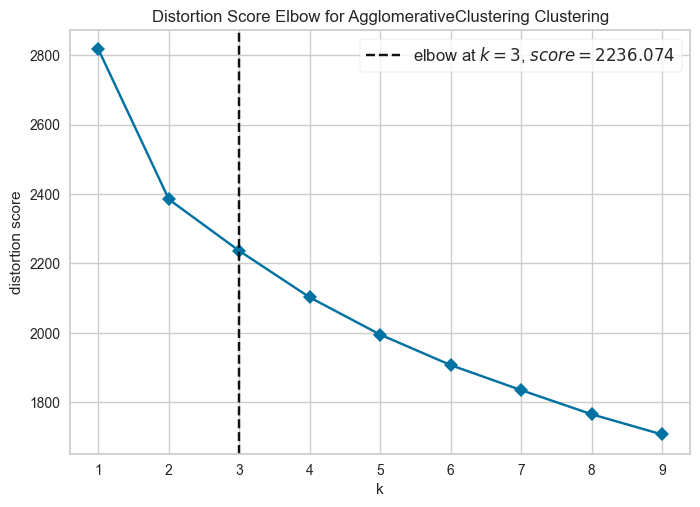

<AxesSubplot: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
data_cluster = data_model[['Ball Recovery', 'Carry','Clearance', 'Dribble', 'Duel', 'Interception', 'Pass', 'Shot', 'Foul Won', 'Foul Committed','total_goals']]

model = AgglomerativeClustering(metric = 'euclidean', linkage = 'ward')
visualizer = KElbowVisualizer(model, k=(1,10), timings = False)
visualizer.fit(data_ss)
visualizer.show()

In [10]:
model_agglomerative_cluster = AgglomerativeClustering(n_clusters = visualizer.elbow_value_, metric = 'euclidean', linkage = 'ward')
y_model = model_agglomerative_cluster.fit_predict(data_ss)
data_model['Labels'] = y_model

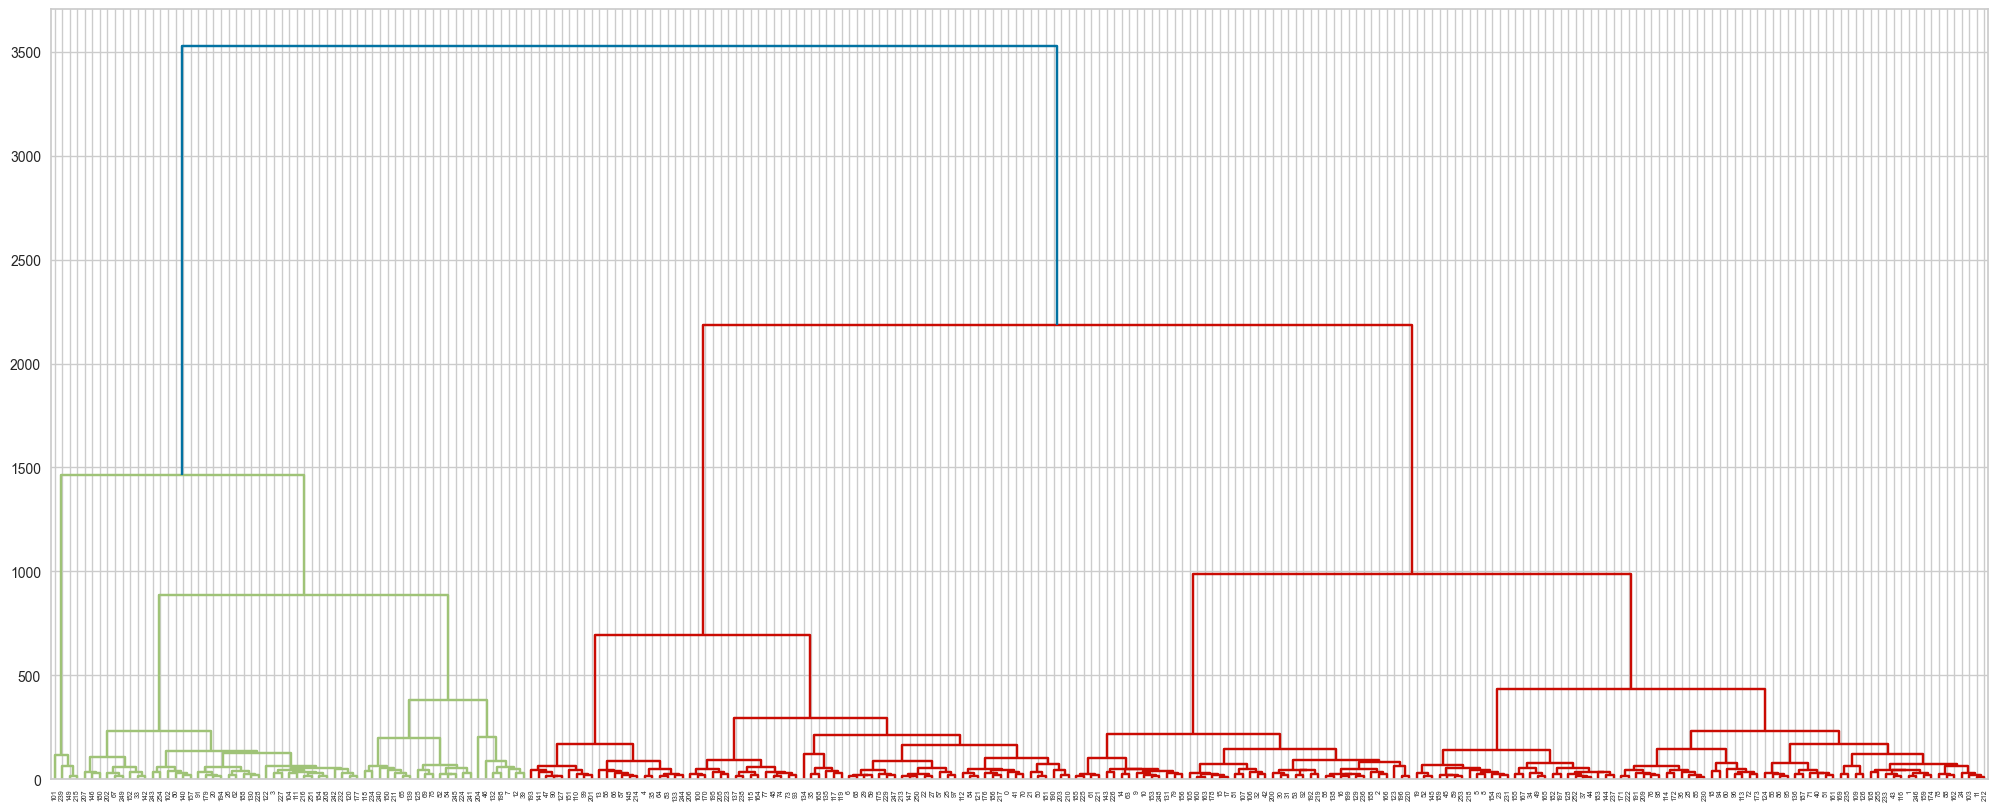

In [11]:
Z = linkage (data_cluster, 'ward')
fig= plt. figure (figsize=(25, 10))
dn = dendrogram(Z)

In [12]:
zero = data_model.loc[(data_model.Labels) == 0]
zero.describe()

,match_id,total_goals,Ball Recovery,Carry,Clearance,Dribble,Duel,Foul Committed,Foul Won,Interception,Pass,Shot,Labels
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.0
mean,60.493506,1.181818,37.149351,328.766234,19.772727,12.720779,29.071429,14.746753,12.597403,10.603896,418.474026,9.961039,0.0
std,36.711603,1.179645,7.229011,106.117507,7.988163,4.598233,8.108824,4.044785,4.433266,4.700742,111.741485,3.933903,0.0
min,1.000000,0.000000,20.000000,139.000000,4.000000,2.000000,11.000000,6.000000,4.000000,3.000000,196.000000,0.000000,0.0
25%,27.250000,0.000000,31.000000,247.250000,13.250000,10.000000,24.000000,12.000000,9.000000,7.000000,333.000000,7.000000,0.0
50%,61.500000,1.000000,37.000000,322.000000,19.000000,12.500000,29.000000,14.500000,12.000000,9.000000,420.000000,10.000000,0.0
75%,89.750000,2.000000,42.000000,398.750000,24.000000,15.000000,34.000000,17.750000,15.000000,13.000000,495.000000,12.000000,0.0
max,127.000000,6.000000,54.000000,571.000000,46.000000,27.000000,49.000000,24.000000,23.000000,28.000000,660.000000,23.000000,0.0


In [13]:
um = data_model.loc[(data_model.Labels) == 1]
um.describe()
# Times que fazem mais progressão
# Times que dão menos chutão
# Driblam mais
# Sofre menos falta
# Times que mais trocam passe e mais finalizam

,match_id,total_goals,Ball Recovery,Carry,Clearance,Dribble,Duel,Foul Committed,Foul Won,Interception,Pass,Shot,Labels
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.0
mean,59.520548,1.315068,44.849315,526.397260,12.041096,20.589041,25.671233,12.315068,14.246575,8.684932,622.506849,16.972603,1.0
std,35.789551,1.442189,8.876735,128.881054,7.541438,5.929764,8.266490,5.115002,4.135822,4.169588,153.962759,5.712979,0.0
min,2.000000,0.000000,20.000000,325.000000,2.000000,5.000000,10.000000,4.000000,4.000000,2.000000,350.000000,5.000000,1.0
25%,31.000000,0.000000,39.000000,438.000000,7.000000,17.000000,20.000000,8.000000,11.000000,6.000000,525.000000,13.000000,1.0
50%,53.000000,1.000000,45.000000,495.000000,10.000000,20.000000,26.000000,12.000000,14.000000,8.000000,594.000000,16.000000,1.0
75%,91.000000,2.000000,50.000000,578.000000,13.000000,25.000000,30.000000,15.000000,17.000000,11.000000,697.000000,21.000000,1.0
max,126.000000,7.000000,69.000000,926.000000,35.000000,33.000000,51.000000,26.000000,23.000000,22.000000,1133.000000,31.000000,1.0


In [14]:
dois = data_model.loc[(data_model.Labels) == 2]
dois.describe()

# Times que em média recuperam mais bolas
# Participa de mais duelos
# Times que realizam menos faltas e sofrem mais
# Times que interceptam mais bolas

,match_id,total_goals,Ball Recovery,Carry,Clearance,Dribble,Duel,Foul Committed,Foul Won,Interception,Pass,Shot,Labels
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.0
mean,98.310345,1.655172,47.655172,383.344828,28.379310,14.931034,40.689655,16.310345,15.931034,13.103448,492.965517,14.689655,2.0
std,22.073098,0.936401,9.255407,111.618699,8.945924,6.839648,7.221513,7.126928,6.215942,4.753531,128.398788,5.794723,0.0
min,55.000000,0.000000,35.000000,220.000000,13.000000,5.000000,28.000000,4.000000,8.000000,5.000000,318.000000,5.000000,2.0
25%,84.000000,1.000000,40.000000,303.000000,21.000000,10.000000,34.000000,10.000000,12.000000,10.000000,366.000000,11.000000,2.0
50%,101.000000,2.000000,45.000000,389.000000,29.000000,14.000000,41.000000,15.000000,15.000000,13.000000,500.000000,14.000000,2.0
75%,118.000000,2.000000,54.000000,459.000000,34.000000,18.000000,45.000000,19.000000,20.000000,15.000000,581.000000,19.000000,2.0
max,128.000000,3.000000,72.000000,637.000000,56.000000,33.000000,53.000000,37.000000,37.000000,24.000000,754.000000,26.000000,2.0
